In [8]:
from pathlib import Path
import glob

import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [9]:
# %%
def make_relations(dpath):
    dpath = Path(dpath)
    paths = [p for p in dpath.glob("./*")]
    out = {p.name: i for i, p in enumerate(paths)}
    return out

def load_image(fname):
    fname = str(fname)
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def transform_sample(transforms, image, mask=None):
    if isinstance(transforms, A.Compose):
        data_dict = transforms(image=image, mask=mask)
        image, mask = data_dict["image"], data_dict["mask"]
    else:
        image, mask = transforms(image, mask)
    return image, mask

def rescale_sample(image, mppxl_current, mppxl_target):
    if mppxl_current == mppxl_target:
        return image
    scale_factor = mppxl_current / mppxl_target
    transform = A.RandomScale(
        scale_limit=[scale_factor - 1.0, scale_factor - 1.0],
        interpolation=cv2.INTER_LANCZOS4,
        p=1,
    )
    image = transform(image=image)["image"]
    return image

def plot_sample(image, target):
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    target = target[0, ...].cpu().detach().numpy()
    plt.figure(figsize=(10,8))
    plt.title(target)
    plt.imshow(image, interpolation=None)
    plt.show()

# def to_onehot(codec, values):
#     value_idxs = codec.transform(values)
#     out = torch.eye(len(codec.classes_))[value_idxs]
#     return out

def array_to_tensor(image, mask):
    aug = ToTensorV2()
    data_dict = aug(image=image, mask=mask)
    image = data_dict['image']
    mask = data_dict['mask']
    return image, mask

def cycle_value_generator(values, max_iterations):
    counter = 0
    len_values = len(list(values))
    if len_values==0:
        return
    while True:
        i = counter % len_values
        counter += 1
        yield values[i]
        if counter==max_iterations:
            break


torch.float32
torch.int64
torch.Size([42, 3, 224, 224])


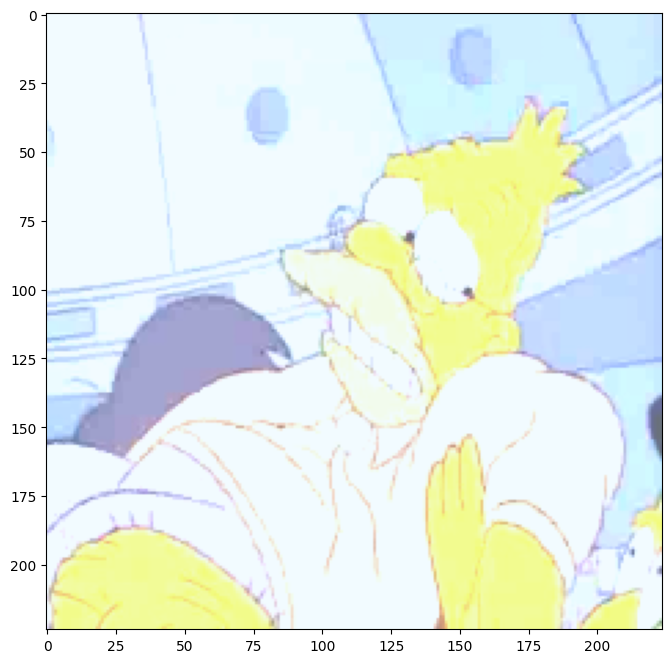

In [10]:
class SimpsonsDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root=Path("./data/journey-springfield/train/simpsons_dataset"),
        transforms=None,
        to_tensor=False,
        shuffle=False,
    ):
        self.root = Path(root)
        self.transforms = transforms
        self.to_tensor = to_tensor
        self.shuffle = shuffle
        self.filedict = {p.name: list(p.glob('*.jpg')) for p in self.root.iterdir()}
        self.relation = {i: classname for i, classname in enumerate(self.filedict.keys())}
        self.num_classes = len(self.filedict.keys())
        self.max_class_quantity = max([len(list(v)) for v in self.filedict.values()])
        self._align()
        if shuffle:
            self._shuffle()

    def __getitem__(self, index):
        if self.shuffle and index == 0:
            self._shuffle()
        i_class = index % self.num_classes
        i_value = index // self.num_classes
        classname = self.relation[i_class]
        image = load_image(self.filedict[classname][i_value])
        target = i_class
        if self.transforms:
            image = transforms(image=image)["image"]
        return image, target

    def __len__(self):
        return self.max_class_quantity * self.num_classes

    def _align(self):
        quantity = self.max_class_quantity
        for key, values in self.filedict.items():
            values = cycle_value_generator(values, quantity)
            self.filedict[key] = list(values)

    def _shuffle(self):
        for key, values in self.filedict.items():
            values = np.random.permutation(values)
            quantity = len(list(values))
            value = cycle_value_generator(values, quantity)
            self.filedict[key] = list(values)

# %% Try using
if __name__ == "__main__":
    transforms = A.Compose([
        A.Resize(224, 224, always_apply=True),
        # A.RandomResizedCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    train_dataset = SimpsonsDataset(
        root=Path("./data/journey-springfield/train/simpsons_dataset/"),
        shuffle=False,
        transforms=transforms,
    )
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=42,
        shuffle=False,
        pin_memory=True,
        num_workers=4,
    )

    # (image, target) = train_dataset[1]
    counter = 0
    for step, (image, target) in enumerate(train_dataloader):
        print(image.dtype)
        print(target.dtype)
        print(image.shape)

        image = image[0,...].permute(1,2,0)
        image = image.detach().cpu().numpy()
        image = np.clip(image * 0.2 + 0.5, 0, 1)

        plt.figure(figsize=(10,8))
        plt.imshow(image)
        plt.show()

        counter += 1
        if counter==1:
            break


In [11]:
from torchvision import models


def dumb_test_model(model):
    x_dumb = torch.rand((1, 3, 224, 224))
    y_dumb = model(x_dumb)
    print(x_dumb.shape)
    print(y_dumb.shape)


def count_parameters(model, is_printing=True):
    count_all = sum(p.numel() for p in model.parameters())
    count_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    if is_printing:
        string = f"{count_train/1e+6:.5f}M from {count_all/1e+6:.5f}M are requires gradients"
        print(string)
    return count_all, count_train


def freeze(model, layer_str="all"):
    for name, param in model.named_parameters():
        if layer_str == "all" or layer_str in name:
            param.requires_grad = False


def unfreeze(model, layer_str="all"):
    for name, param in model.named_parameters():
        if layer_str == "all" or layer_str in name:
            param.requires_grad = True


if __name__ == "__main__":
    model = models.efficientnet_b0(pretrained=True)
    model.classifier = nn.Linear(1280, 42)
    dumb_test_model(model)
    freeze(model)
    unfreeze(model, 'features.4')
    unfreeze(model, 'features.5')
    unfreeze(model, 'features.6')
    unfreeze(model, 'features.7')
    unfreeze(model, 'features.8')
    unfreeze(model, 'classifier')

    # weights = torchvision.models.ResNet18_Weights.DEFAULT
    # model = models.resnet18(weights=weights)
    # model.fc = nn.Linear(512, 42)
    # dumb_test_model(model)
    # freeze(model)
    # unfreeze(model, 'layer1')
    # unfreeze(model, 'layer2')
    # unfreeze(model, 'layer3')
    # unfreeze(model, 'layer4')
    # unfreeze(model, 'fc')
    # count_parameters(model, is_printing=True)

    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)


torch.Size([1, 3, 224, 224])
torch.Size([1, 42])


/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for name, param in model.named_parameters():
    # print(name)
    pass

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(
    params=[
        {"params": model.features[5].parameters(), "lr": 1e-5},
        {"params": model.features[6].parameters(), "lr": 2e-5},
        {"params": model.features[7].parameters(), "lr": 3e-5},
        {"params": model.features[8].parameters(), "lr": 4e-5},
        {"params": model.classifier.parameters()},
    ],
    lr=3e-4,
)
# optimizer = torch.optim.AdamW(
#     params=[
#         {"params": model.layer1.parameters(), "lr": 1e-5},
#         {"params": model.layer2.parameters(), "lr": 2e-5},
#         {"params": model.layer3.parameters(), "lr": 3e-5},
#         {"params": model.layer4.parameters(), "lr": 4e-5},
#         {"params": model.fc.parameters()},
#     ],
#     lr=3e-4,
# )

loss_fn = nn.CrossEntropyLoss()

transforms = A.Compose([
    A.Resize(224, 224, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
train_dataset = SimpsonsDataset(
    root=Path("./data/journey-springfield/train/simpsons_dataset/"),
    shuffle=True,
    transforms=transforms,
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=42,
    shuffle=False,
    pin_memory=True,
    num_workers=10,
)

global_step = 0
loss_history = []
for epoch in range(25):
    for step, (image, target) in enumerate(train_dataloader):
        image = image.to(device).float()
        target = target.to(device).long()
        pred = model(image)
        loss = loss_fn(pred, target)
        loss_value = loss.detach().cpu().numpy()
        loss_history.append(loss_value)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        if global_step % 1000 == 0:
            print(f"Epoch: {epoch:02d}, "
                  f"global_step: {global_step:06d}, "
                  f"train loss: {np.mean(loss_history[-1000:]):.5f}")
        global_step += 1

Epoch: 00, global_step: 000000, train loss: 3.76383
Epoch: 00, global_step: 001000, train loss: 2.11340
Epoch: 00, global_step: 002000, train loss: 1.20479
Epoch: 01, global_step: 003000, train loss: 1.05265
Epoch: 01, global_step: 004000, train loss: 0.96986
Epoch: 02, global_step: 005000, train loss: 0.90693
Epoch: 02, global_step: 006000, train loss: 0.85719
Epoch: 03, global_step: 007000, train loss: 0.83609
Epoch: 03, global_step: 008000, train loss: 0.82305
Epoch: 04, global_step: 009000, train loss: 0.79734
Epoch: 04, global_step: 010000, train loss: 0.77438
Epoch: 04, global_step: 011000, train loss: 0.76607
Epoch: 05, global_step: 012000, train loss: 0.74222
Epoch: 05, global_step: 013000, train loss: 0.74323
Epoch: 06, global_step: 014000, train loss: 0.73199
Epoch: 06, global_step: 015000, train loss: 0.71289
Epoch: 07, global_step: 016000, train loss: 0.70898
Epoch: 07, global_step: 017000, train loss: 0.70074
Epoch: 08, global_step: 018000, train loss: 0.67997
Epoch: 08, g

In [14]:
def current_date_and_time():
    import datetime as dt
    return dt.datetime.now().strftime("%Y%m%d_%H%M%S")

def save_model(model, fn="./model_full.pt"):
    """ Save entire net """
    torch.save(model, str(fn))

def save_params(model, fn="./model_params.pth"):
    """ Save only the parameters """
    torch.save(model.state_dict(), str(fn))

def restore_model(fn="./model_full.pt"):
    """ Restore full model """
    model = torch.load(str(fn))
    return model

def restore_params(model, fn="./model_params.pth"):
    """ restore model's parameters """
    state_dict = torch.load(str(fn))
    model.load_state_dict(state_dict)
    return model

# Save model and weights
if __name__ == "__main__":
    date = current_date_and_time()
    model_name = model.__class__.__name__
    
    save_model(model, fn=f"./models/{date}_{model_name}_full.pt")
    save_params(model, fn=f"./models/{date}_{model_name}_weights.pth")

    model = restore_model(fn=f"./models/{date}_{model_name}_full.pt")
    model = restore_params(model, fn=f"./models/{date}_{model_name}_weights.pth")

[PosixPath('data/journey-springfield/testset/testset/img0.jpg'), PosixPath('data/journey-springfield/testset/testset/img1.jpg'), PosixPath('data/journey-springfield/testset/testset/img2.jpg'), PosixPath('data/journey-springfield/testset/testset/img3.jpg'), PosixPath('data/journey-springfield/testset/testset/img4.jpg'), PosixPath('data/journey-springfield/testset/testset/img5.jpg'), PosixPath('data/journey-springfield/testset/testset/img6.jpg'), PosixPath('data/journey-springfield/testset/testset/img7.jpg'), PosixPath('data/journey-springfield/testset/testset/img8.jpg'), PosixPath('data/journey-springfield/testset/testset/img9.jpg'), PosixPath('data/journey-springfield/testset/testset/img10.jpg'), PosixPath('data/journey-springfield/testset/testset/img11.jpg'), PosixPath('data/journey-springfield/testset/testset/img12.jpg'), PosixPath('data/journey-springfield/testset/testset/img13.jpg'), PosixPath('data/journey-springfield/testset/testset/img14.jpg'), PosixPath('data/journey-springfiel

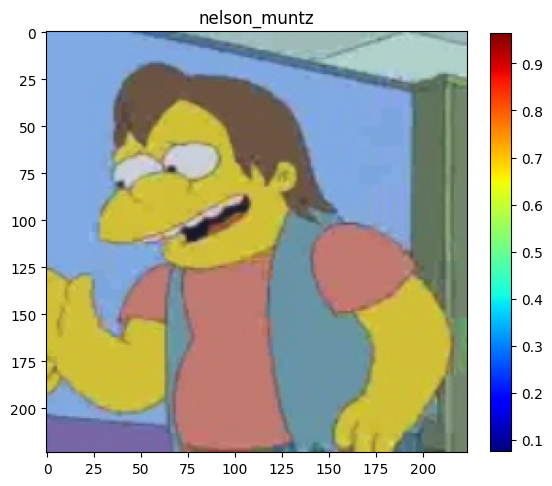

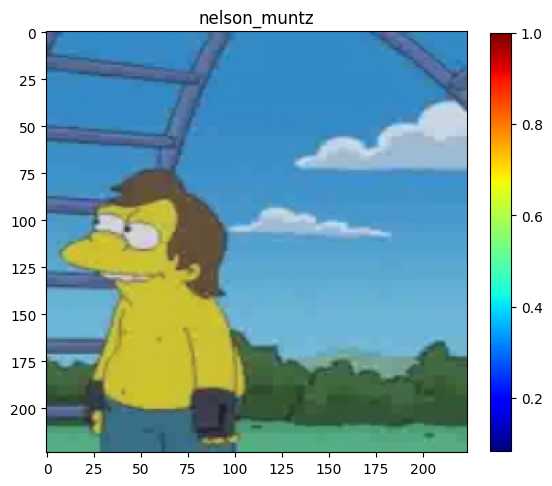

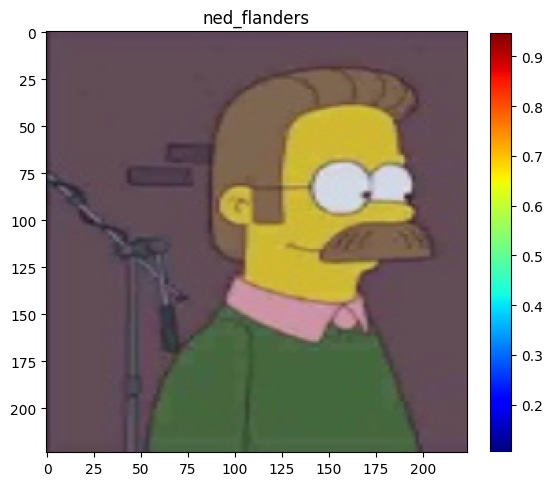

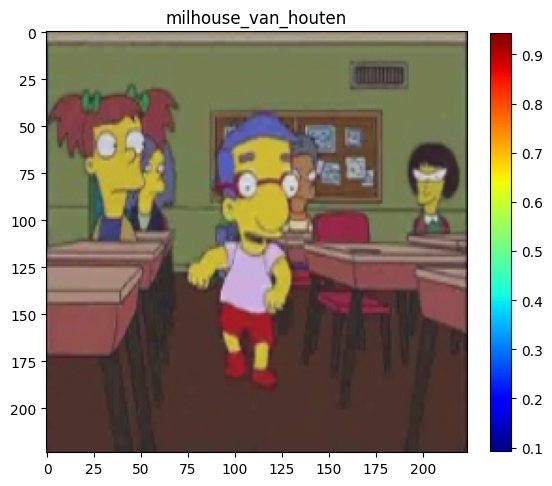

In [15]:
transforms = A.Compose([
    A.Resize(224, 224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def test_image_generator(dpath=Path("./data/journey-springfield/testset/testset/")):
    filelist=dpath.glob("*.jpg")
    filelist=list(filelist)
    filelist.sort(key=lambda fn: int(fn.stem[3:]))
    print(filelist)
    for fn in filelist:
        image=load_image(fn)
        image=transforms(image=image)['image']
        yield image, fn.name

# Predict test images
img_gen=test_image_generator()
answers=[]
model.eval()
with torch.no_grad():
    for i_image, (image, img_name) in enumerate(img_gen):
        img=image.float()
        img=img.unsqueeze(0)
        img=img.to(device)

        output=model(img)

        pred=output[0, ...].argmax(0)
        pred=pred.detach().cpu().numpy()
        pred=int(pred)
        answer=train_dataset.relation[int(pred)]
        answers.append([img_name, answer])

        if i_image % 320 == 0:
            image = image.permute(1, 2, 0)
            image = image * 0.2 + 0.5
            image = np.clip(image, 0, 1)
            fig, ax=plt.subplots(1, 1, figsize=(6, 8))
            h0=ax.imshow(image, cmap='jet')
            plt.title(train_dataset.relation[pred])
            plt.colorbar(h0, ax=ax, fraction=0.045)
            plt.show()


In [16]:
# SAVE results to submission.csv
import csv
fields=["Id","Expected"]
with open(r'submission.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    for answer in answers:
        writer.writerow(answer)

In [17]:
dict0 = {}
with open(r'submission.csv', "r") as f:
    reader = csv.reader(f)
    title = next(reader)  # read fields
    for row in reader:
        dict0[row[0]] = row[1]

dict1 = {}
with open(r'submission_test.csv', "r") as f:
    reader = csv.reader(f)
    title = next(reader)  # read fields
    for row in reader:
        dict1[row[0]] = row[1]

for key in dict0.keys():
    pred = dict0[key]
    true = dict1[key]
    # print(key, pred, true)

acc = sum([dict0[k]==dict1[k] for k in dict0.keys()]) / len(dict0)
print(acc)

0.9919273461150353
